# Neural Prohpet
newpycaret env

https://github.com/ourownstory/neural_prophet
https://neuralprophet.com/how-to-guides/feature-guides/global_local_modeling.html


In [5]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import snowflake.connector
import os
from sklearn.impute import SimpleImputer
from neuralprophet import NeuralProphet, set_log_level
from datetime import datetime, timedelta
from dateutil import relativedelta

2. Load Data
_______________________________________________________________

### To Do: copy and paste in to a new chunk, enter credentials and run to save in environment. Then delete chunk
%env snowflakeuser=<your_snowflake_username> <br>
%env snowflakepass=<your_snowflake_password>

In [3]:
# Query Snowflake

# Snowflake connection parameters
connection_params = {
    "user": os.environ['snowflakeuser'],
    "password": os.environ['snowflakepass'],
    "account": "zib52348.us-east-1",
    "role": "ACCOUNTADMIN",
    "warehouse": "REPORTING",
    "database": "ANALYTICS",
    "schema": "FORECASTING",
}

# Establish a connection to Snowflake
conn = snowflake.connector.connect(**connection_params)

with open('net_sales_query.sql', 'r') as query:
    # connection == the connection to your database, in your case prob_db
    df_initial = pd.read_sql_query(query.read(), conn)

# Close the connection
conn.close()

WARNING - (py.warnings._showwarnmsg) - C:\Users\crudek\AppData\Local\Temp\ipykernel_10272\2623517584.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_initial = pd.read_sql_query(query.read(), conn)



In [48]:
##### INITIAL VARIABLE DECLARATION #####

# Get the current date
current_date = pd.to_datetime(datetime.today().date())

# Calculate the first day of the current month
first_day_of_current_month = pd.to_datetime(current_date.replace(day=1))

# Calculate the first day of the next month
first_day_of_next_month = datetime(current_date.year, current_date.month + 1, 1)

# Calculate the first day of the last month
last_day_of_last_month = first_day_of_current_month - timedelta(days=1)
first_day_of_last_month = last_day_of_last_month.replace(day=1)




### MANUAL INPUTS ###

# how much data do you want to keep to train models. 
end_of_data = first_day_of_last_month # the default which is the max date this should ever be because it would include all months that have full data
#end_of_data = pd.to_datetime('2022-12-01')

# forecast horizon = how many months in to the future you want to forecast. So, we will forecast this many months past the above end_of_data
fh = 15




### FORECAST HORIZON (FH) DATAFRAME ###

end_of_data_next_month = end_of_data + relativedelta.relativedelta(months=1, day=1)
end_of_data_df = pd.DataFrame({'end_of_data': [end_of_data_next_month]})
end_of_data_df['end_of_data'] = pd.to_datetime(end_of_data_df['end_of_data'])

# Create a date range for the next 12 months
next_12_months = pd.date_range(start=end_of_data_df['end_of_data'].iloc[0], periods=fh, freq='MS')

fh_dates_df = pd.DataFrame({'MONTH': next_12_months})




### INITIAL DATA PREPARATION ###

# create copy of df_d
df = df_initial.copy(deep=True)

# convert month field to date
df["MONTH"] = pd.to_datetime(df["MONTH"])

# Some random months will have data that we want to remove (* Want to test without July though)
df = df[["DEP_ENT", "MONTH", "NET_SALES"]]  # select fields of interest
df = df.sort_values(['DEP_ENT', 'MONTH'])  # reorder dataframe

# remove data after the 'end of data' setting above
df_sub = df[df['MONTH'] <= end_of_data]

# create series
df_s = df_sub.set_index(['DEP_ENT','MONTH'])['NET_SALES']
# convert back to dataframe
df_d = df_s.to_frame()
#reset index
df_d.reset_index(inplace=True)




### IMPUTE MISSIG VALUES WITH MONTH AND MEAN OR 0 ###

# list of each dep-ent
all_dep_ent = df_d['DEP_ENT'].unique()

# Create empty dataframe
df_subset_all = pd.DataFrame()

for i in all_dep_ent:
    
    temp_subset = df_d[df_d['DEP_ENT'] == i]
    
    # Define the minimum and maximum dates
    min_date = min(temp_subset['MONTH'])
    max_date = end_of_data # max(temp_subset['MONTH'])

    # Generate a list of dates for each month in between
    date_range = []
    current_month = min_date.replace(day=1)
    while current_month <= max_date:
        date_range.append(current_month)
        current_month = current_month + timedelta(days=32)
        current_month = current_month.replace(day=1)

    # Create a DataFrame from the list of dates
    date_range_df = pd.DataFrame({'MONTH': date_range})

    df_merged = pd.merge(date_range_df, temp_subset, on='MONTH', how='left')

    #Finding the mean of the column having NaN
    mean_value = df_merged['NET_SALES'].mean()
    
    # Replace NaNs in column S2 with the
    # mean of values in the same column
    # could use mean or 0
    df_merged['NET_SALES'].fillna(value=0, inplace=True)
    
    df_merged['DEP_ENT'] = i

    df_subset_all = pd.concat([df_subset_all,df_merged])

# change negatives to 0
df_subset_all.loc[df_subset_all['NET_SALES'] < 0, 'NET_SALES'] = 0


### FILL DATES THROUGH END OF FORECAST HORIZON ###

# Create empty dataframe
df_subset_all2 = pd.DataFrame()

for i in all_dep_ent:
    # filter to one dep_ent
    temp_subset2 = df_subset_all[df_subset_all['DEP_ENT'] == i]
    # temp result
    temp_result2 = pd.merge(temp_subset2, fh_dates_df, on='MONTH', how='outer')
    temp_result2['DEP_ENT'] = i
    
    # combine for all dep_ents
    df_subset_all2 = pd.concat([df_subset_all2,temp_result2])

# rename columns for prophet
df_rename = df_subset_all2.copy()
df_rename.rename(columns={'MONTH': 'ds', 'NET_SALES': 'y', 'DEP_ENT': 'ID'}, inplace=True)

In [49]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

# Initialize a dictionary to store individual models and forecasts
id_models = {}
id_forecasts = {}

# Group data by ID
grouped = df_rename.groupby('ID')

# Loop through each group (ID) and create models and forecasts
for group_name, group_data in grouped:
    group_data = group_data.rename(columns={'ds': 'ds', 'y': 'y'})
    group_data_trim = group_data[group_data['ds'] <= end_of_data]
    
    # Initialize and train the model
    model = NeuralProphet()
    model.fit(group_data_trim, freq="MS")
    
    # Store the model for the current ID
    id_models[group_name] = model
    
    # Create a dataframe with future dates for prediction
    future = model.make_future_dataframe(group_data_trim, periods=fh, n_historic_predictions=len(group_data_trim))
    
    # Make predictions for the next 12 periods
    forecast = model.predict(future)
    
    # Store the forecast for the current ID
    id_forecasts[group_name] = forecast

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 6it [00:00, ?it/s]

Finding best initial lr:   0%|          | 0/204 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

In [50]:
# Initialize a dataframe to store final predictions
all_np_preds = pd.DataFrame()

# Loop through each group (ID) and get final pred
for group_name, group_data in grouped:
    
    # create temp table with fcasts for id (dep-ent)
    temp_fcast = id_forecasts[group_name]
    
    # filter to just the predictions in the future
    temp_fcast = temp_fcast.tail(fh)[["ds", "yhat1"]]
    
    # add id (dep-ent)
    temp_fcast['ID'] = group_name

    # create master list of predictions    
    all_np_preds = pd.concat([all_np_preds, temp_fcast])

In [51]:
### AFTER THE LOOP ###

# rename index col
all_np_preds.rename(columns={'ds': 'MONTH', 'yhat1': 'PRED', 'ID': 'DEP_ENT' }, inplace=True)

# initial sales pull
sales = df_initial
# select cols
sales = sales[["DEP_ENT", "MONTH", "NET_SALES"]]
sales["MONTH"] = pd.to_datetime(sales["MONTH"])
# only include sales data for the full months we have
sales = sales[sales['MONTH'] <  pd.to_datetime(first_day_of_current_month)]

# combine prediction data and original sales data
merged = pd.merge(all_np_preds, sales, how='left', on=['DEP_ENT', 'MONTH'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\crudek\AppData\Local\Temp\ipykernel_10272\3950419347.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales["MONTH"] = pd.to_datetime(sales["MONTH"])



In [52]:
### BUDGET ###

# Establish a connection to Snowflake
conn = snowflake.connector.connect(**connection_params)

with open('budget_query.sql', 'r') as query:
    # connection == the connection to your database, in your case prob_db
    budg = pd.read_sql_query(query.read(), conn)

# Close the connection
conn.close()

# convert month to datetime
budg["MONTH"] = pd.to_datetime(budg["MONTH"])
# select cols
budg = budg[["MONTH", "BUDGET_AMOUNT", "DEP_ENT"]]

WARNING - (py.warnings._showwarnmsg) - C:\Users\crudek\AppData\Local\Temp\ipykernel_10272\690824450.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  budg = pd.read_sql_query(query.read(), conn)



In [53]:
# combine prediction/sales data with budget data
merged2 = pd.merge(merged, budg, how='left', on=['DEP_ENT', 'MONTH'])

# write csv
merged2.to_csv('np_pred.csv')

In [55]:
sales.filter(DEP_ENT = ['220_155', '220_310'])

TypeError: filter() got an unexpected keyword argument 'DEP_ENT'

In [64]:
a_220_155 = sales[sales['DEP_ENT'] == '220_155'].sort_values(by=['MONTH'])

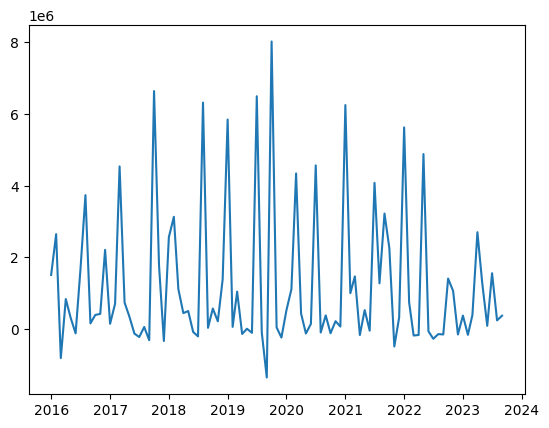

In [65]:
plt.plot(a_220_155['MONTH'], a_220_155['NET_SALES'])
plt.show()

In [67]:
sales.to_csv('sales.csv')